In [1]:
using Plots
using LinearAlgebra
using DelimitedFiles
using Distributions
using StatsBase
using ScikitLearn
using IterTools
@sk_import linear_model: LinearRegression
gr()

Plots.GRBackend()

# 例48 リッジ回帰

- 図5.1は「例49」の実行例となっているけど，48の間違い

In [2]:
function ridge(X, y, λ=0)
    n, p = size(X)
    
    # X, yの正規化
    Xbar = mean(X, dims=1)
    s = std(X, dims=1)
    X = (X .- Xbar) ./ s
    ybar = mean(y)
    y .-= ybar
    
    β = inv(X' * X .+ n .* λ .* (zeros(p, p) + I)) * X' * y
    β = β ./ s'
    β0 = ybar .- Xbar * β
    return Dict("beta" => β, "beta0" => β0)
end

ridge (generic function with 2 methods)

In [3]:
df = readdlm("crime.txt", '\t')
X = df[:, 3:end];
y = df[:, 1];
p = size(X)[2]
λseq = collect(0:0.5:50);
λsize = length(λseq)
λlog = zeros(λsize, p)

for i in 1:λsize
    βi = ridge(X, y, λseq[i])["beta"]
    λlog[i, :] = βi
end

ridge(X, y)

Dict{String,Array{Float64,2}} with 2 entries:
  "beta0" => [-228.311]
  "beta"  => [10.9807; -6.08853; … ; 0.377044; 5.50047]

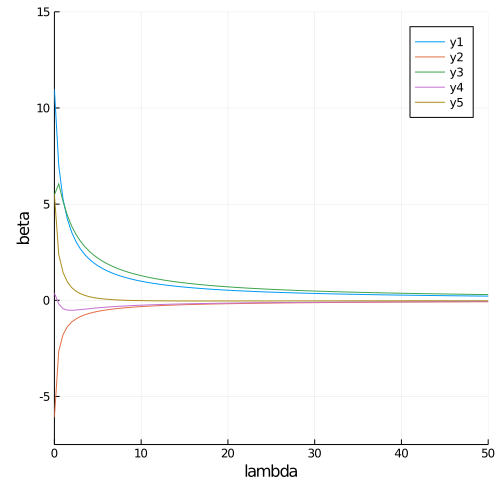

In [4]:
pp = plot(size=(500, 500), xlim=(0, 50), ylim=(-7.5, 15), xlabel="lambda", ylabel="beta")
for i in 1:p
    plot!(pp, λseq, λlog[:, i])
end
pp

# 例49 劣微分の例題

In [5]:
x_seq = collect(-2:0.05:2);
y = x_seq .^ 2 .- 3 .* x_seq .+ abs.(x_seq);

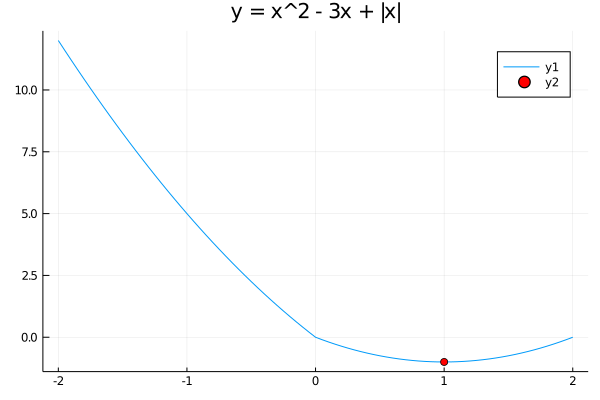

In [6]:
pp = plot(figsize=(500, 500), title="y = x^2 - 3x + |x|")
plot!(x_seq, y)
plot!([1], [-1], seriestype=:scatter, color=:red)
pp

In [7]:
x_seq = collect(-2:0.05:2);
y = x_seq .^ 2 .+ x_seq .+ 2 .* abs.(x_seq);

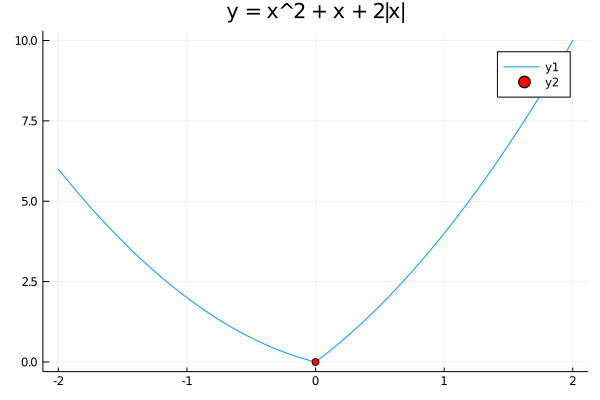

In [8]:
pp = plot(figsize=(500, 500), title="y = x^2 + x + 2|x|")
plot!(x_seq, y)
plot!([0], [0], seriestype=:scatter, color=:red)
pp

# §5.3 Lasso

# 図5.4 soft-threshold

In [9]:
softTH(x, λ=5) = sign.(x) .* max.(abs.(x) .- λ, 0)

softTH (generic function with 2 methods)

In [10]:
x_seq = collect(-10:1:10);
y_seq = softTH.(x_seq);

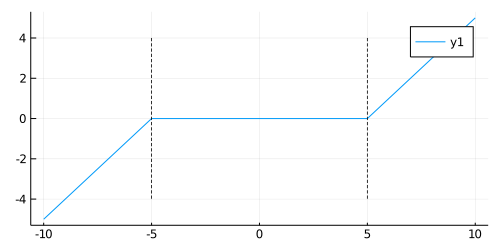

In [11]:
pp = plot(size=(500, 250))
plot!(pp, x_seq, y_seq)
plot!(pp, [-5, -5], [4, -4], color=:black, lw=0.8, ls=:dash, label="")
plot!(pp, [5, 5], [4, -4], color=:black, lw=0.8, ls=:dash, label="")

# Lasso

In [12]:
function lasso(X, y, λ=0)
    n, p = size(X)
    
    # X, yの正規化
    Xbar = mean(X, dims=1)
    s = std(X, dims=1)
    X = (X .- Xbar) ./ s
    ybar = mean(y)
    y .-= ybar
    
    # 計算
    ϵ = 1
    β = zeros(p)
    βold = zeros(p)
    
    # for _ in 1:10
    while ϵ > 0.001
        # println(ϵ)
        for j in 1:p
            index = [i for i in 1:p if i != j]
            r = y .- X[:, index] * β[index]
            β[j] = softTH((r' * X[:, j] ./ n), λ)
        end
        ϵ = maximum(abs.(β - βold))
        βold .= β
    end
    β = β ./ s'
    β0 = ybar .- Xbar * β
    return Dict("beta" => β, "beta0" => β0)
end

lasso (generic function with 2 methods)

# 例50 リッジ回帰と同じデータにLassoを適用するϵ

In [13]:
df = readdlm("crime.txt", '\t')
X = df[:, 3:end];
y = df[:, 1];
lasso(X, y, 3.3)

Dict{String,Array{Float64,2}} with 2 entries:
  "beta0" => [486.322]
  "beta"  => [10.5343; -5.01258; … ; 0.152543; 3.53221]

In [14]:
df = readdlm("crime.txt", '\t')
X = df[:, 3:end];
y = df[:, 1];
p = size(X)[2]
λseq = collect(0:0.5:50);
λsize = length(λseq)
λlog = zeros(λsize, p)

for i in 1:λsize
    βi = lasso(X, y, λseq[i])["beta"]
    λlog[i, :] = βi
end

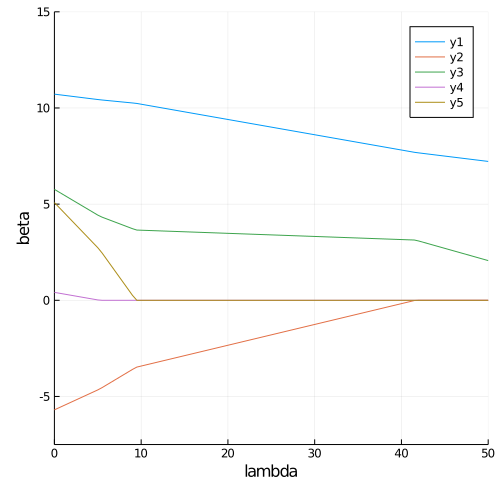

In [15]:
pp = plot(size=(500, 500), xlim=(0, 50), ylim=(-7.5, 15), xlabel="lambda", ylabel="beta")
for i in 1:p
    plot!(pp, λseq, λlog[:, i])
end
pp

# 例51 scikit-learnを使ってLasso

In [16]:
@sk_import linear_model: Lasso
@sk_import linear_model: LassoCV

PyObject <class 'sklearn.linear_model._coordinate_descent.LassoCV'>

In [17]:
Las = Lasso(alpha=20)
ScikitLearn.fit!(Las, X, y)
Las.coef_

5-element Array{Float64,1}:
 11.090675937988719 
 -5.280075703016873 
  4.654942819497639 
  0.5501593157274981
  2.8432429539182325

In [18]:
Lcv = LassoCV(alphas=collect(0.1:0.1:30), cv=10)
ScikitLearn.fit!(Lcv, X, y)

PyObject LassoCV(alphas=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,...
       26.5, 26.6, 26.7, 26.8, 26.9, 27. , 27.1, 27.2, 27.3, 27.4, 27.5,
       27.6, 27.7, 27.8, 27.9, 28. , 28.1, 28.2, 28.3, 28.4, 28.5, 28.6,
       28.7, 28.8, 28.9, 29. , 29.1, 29.2, 29.3, 29.4, 29.5, 29.6, 29.7,
       29.8, 29.9, 30. ]),
        copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto'

In [19]:
Lcv.alpha_

30.0

In [20]:
Lcv.coef_

5-element Array{Float64,1}:
 11.145711479667478 
 -4.8745813747159605
  4.243678809976327 
  0.6374891136020497
  1.5124890190941997

# 図5.8 GLMNet.jlの適用

In [21]:
using GLMNet

In [22]:
path = glmnet(X, y)

Least Squares GLMNet Solution Path (65 solutions for 5 predictors in 301 passes):
───────────────────────────────
      df    pct_dev           λ
───────────────────────────────
 [1]   0  0.0        155.152   
 [2]   1  0.0482691  141.369   
 [3]   1  0.088343   128.81    
 [4]   1  0.121613   117.367   
 [5]   1  0.149234   106.94    
 [6]   1  0.172166    97.4402  
 [7]   1  0.191204    88.7839  
 [8]   1  0.20701     80.8965  
 [9]   1  0.220133    73.7099  
[10]   1  0.231027    67.1617  
[11]   2  0.24395     61.1953  
[12]   2  0.255401    55.7588  
[13]   2  0.264908    50.8054  
[14]   2  0.2728      46.292   
[15]   3  0.279695    42.1795  
[16]   3  0.287823    38.4324  
[17]   3  0.294566    35.0182  
[18]   3  0.300165    31.9073  
[19]   3  0.304798    29.0727  
[20]   3  0.30866     26.49    
[21]   3  0.311865    24.1367  
[22]   3  0.314527    21.9924  
[23]   3  0.316737    20.0387  
[24]   3  0.318571    18.2585  
[25]   3  0.320094    16.6365  
[26]   3  0.321359    

In [23]:
glmcv = glmnetcv(X, y, nfolds=10)

Least Squares GLMNet Cross Validation
65 models for 5 predictors in 10 folds
Best λ 18.259 (mean loss 67615.612, std 14202.740)

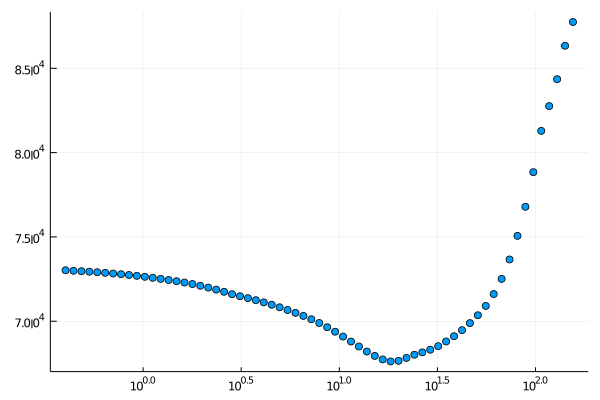

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error


In [24]:
loss_y = glmcv.meanloss;
lambda_x = glmcv.lambda;

pp = plot(figsize=(600, 300))
plot!(pp, lambda_x, loss_y, seriestype=:scatter, xscale=:log10, label="")
pp